Gerekli Drive bağlantılarının yapılması: 

In [1]:
import pandas as pd
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls

drive  sample_data


In [4]:
os.environ['KAGGLE_CONFIG_DIR']= "/content/drive/MyDrive/Colab_Notebooks/input"

In [5]:
%cd "/content/drive/MyDrive/Colab_Notebooks/input"

/content/drive/MyDrive/Colab_Notebooks/input


In [6]:
!pwd

/content/drive/MyDrive/Colab_Notebooks/input


In [64]:
!kaggle datasets download -d deadskull7/fer2013

401 - Unauthorized


In [9]:
!ls

assets				   keras_metadata.pb  myy_model.zip
emotion-detection-using-cnn.ipynb  Mcp1		      projebitis
fer2013.csv			   ModelCheckpoint    saved_model.pb
kaggle.json			   myy_model	      variables


In [10]:
!unzip \*.zip && rm *.zip

Archive:  myy_model.zip
replace saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: saved_model.pb          
replace keras_metadata.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: keras_metadata.pb       
replace variables/variables.index? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: variables/variables.index  
replace variables/variables.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: variables/variables.data-00000-of-00001  


In [11]:
!ls

assets				   keras_metadata.pb  projebitis
emotion-detection-using-cnn.ipynb  Mcp1		      saved_model.pb
fer2013.csv			   ModelCheckpoint    variables
kaggle.json			   myy_model


In [12]:
#Set içeriğindeki ilk 5 eğitim içeriğini gördüm. Veri görselleştirilir.
data=pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/input/fer2013.csv')
print("Number of Labels:", data.emotion.max() + 1)
pd.set_option('max_colwidth',100)
data.head(5)

Number of Labels: 7


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 154 153 164 173 178 185 185 189 187 186 193 194 185 ...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38 39 74 138 161 164 179 190 201 210 216 220 224 222...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 19 43 52 13 26 40 59 65 12 20 63 99 98 98 111 75 62...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84 115 127 137 142 151 156 155 149 153 152 157 160 1...,Training


Gerekli paket ve kütüphanelerin kurulumu:

In [13]:
import tensorflow as tf
from tensorflow import keras as ks
import numpy as np
import pandas as pd

import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D,BatchNormalization
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.utils import np_utils
from keras.preprocessing import image
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from matplotlib import pyplot as plt
%matplotlib inline

from keras.callbacks import ModelCheckpoint

In [14]:
model = ks.Sequential([
    ks.layers.LSTM(units=1, input_shape=(5, 1))
])

**Eğitim ve test performansının ölçüldüğü veri sayılarını inceleyelim.**
Usage kolonunda verisetindeki örnekler kaç gruba ayrıldığını görebiliriz. Kaggleda genelde bu şekilde submit sonrası asıl test edilmesi için verisetinden bir kısmını "PrivateTest" olarak ayırırlar.
privateTest olanlar daha sonra test etmek içindir. Public olanlar ise en sondaki başarım oranını test etmek içindir. 

In [15]:
data["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [16]:
np.unique(data["Usage"].values.ravel()) 

print('Eğitim verisetindeki örnek sayısı: %d'%(len(data[data.Usage == "Training"])))

Eğitim verisetindeki örnek sayısı: 28709


In [17]:
#sadece eğitim örneklerini train_data değişkenine aldık
train_data = data[data.Usage == "Training"]

In [18]:
#eğitim örneklerinin piksel değerleri bize tablo halinde yan yana verildiği için boşluklardan parse ederek liste olarak değişkene aldık. Büyük bir matris oluştu ve her biri içinde pixeller mevcut.
train_pixels = train_data.pixels.str.split(" ").tolist() 
print(len(train_pixels))
train_pixels = pd.DataFrame(train_pixels, dtype=int)
train_images = train_pixels.values
train_images = train_images.astype(np.float64)

print(train_images)
print(train_images.shape)

28709


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: Could not cast to int64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  exec(code_obj, self.user_global_ns, self.user_ns)


[[ 70.  80.  82. ... 106. 109.  82.]
 [151. 150. 147. ... 193. 183. 184.]
 [231. 212. 156. ...  88. 110. 152.]
 ...
 [ 74.  81.  87. ... 188. 187. 187.]
 [222. 227. 203. ... 136. 136. 134.]
 [195. 199. 205. ...   6.  15.  38.]]
(28709, 2304)


In [19]:
#Görüntüyü 48x48 piksel şeklinde göstermek için bir fonksiyon tanımlayalım, reshape ve gri seviye belirt. 
def show(img, label="None"):
    show_image = img.reshape(48,48)
    plt.axis('off')
    plt.title(label)
    plt.imshow(show_image, cmap='gray')

In [20]:
#dict ve duygu_siniflari = ["Anger", "Disgust", "Fear", "Happy", "Neutral", "Sadness", "Surprise"]
labels = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Neutral",
    5: "Sad",
    6: "Surprise"
}

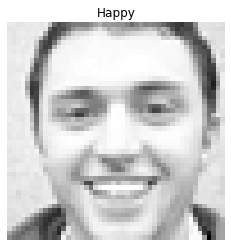

In [21]:
# veriseti içindeki eğitim kümesinden indexli bir örnek görseli deneyelim 
label_index = train_data.emotion
index = label_index[30]
label = labels[index]
show(train_images[30], label)

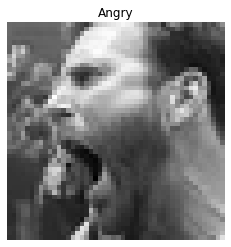

In [23]:
label_index = train_data.emotion
index = label_index[28705]
label = labels[index]
show(train_images[28705], label)

Eğitim kümesinde kaç sınıf bulunuyor, görelim.

In [24]:
train_labels_flat = train_data["emotion"].values.ravel()
train_labels_count = np.unique(train_labels_flat).shape[0]
print('Farklı yüz ifadelerinin (duygu durumları) adedi: %d'%train_labels_count)

Farklı yüz ifadelerinin (duygu durumları) adedi: 7


**One Hot ile eğitim kümesindeki verilerin her birine düşen sınıfı yani eğitim işlemi boyutunu görelim.**

In [25]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [26]:
x_train = dense_to_one_hot(train_labels_flat, train_labels_count)
x_train = x_train.astype(np.uint8)

print(x_train.shape)

(28709, 7)


**TEST VERİSİ ÖN İŞLEME ADIMI**
Eğitim işlemi için veri kümesinde ayrılmış olan PublicTest kısmını alırız.

In [27]:
y_train = dense_to_one_hot(train_labels_flat, train_labels_count)
y_train = y_train.astype(np.uint8)

print(y_train.shape)

(28709, 7)


In [28]:
np.unique(data["Usage"].values.ravel()) 

print('Test verisetindeki örnek sayısı: %d'%(len(data[data.Usage == "PublicTest"])))

Test verisetindeki örnek sayısı: 3589


In [29]:
test_data = data[data.Usage == "PublicTest"] 
test_pixels = test_data.pixels.str.split(" ").tolist() 

test_pixels = pd.DataFrame(test_pixels, dtype=int)
test_images = test_pixels.values
test_images = test_images.astype(np.float64)

print(test_images.shape)
#Toplam 3589 görüntü ve her birinde 2304 pixel değeri ile ifade ediliyor.

(3589, 2304)


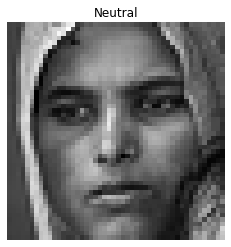

In [32]:
#eğitim kümesinden bir örenk alıp, test edelim
test_label_index = test_data["emotion"].values
index = test_label_index[3588]
label = labels[index]
show(test_images[3588], label)

One Hot ile test kümesindeki verilerin her birine düşen sınıfı yani eğitim işlemi boyutunu görelim.
3589 görüntü ve yine 7 sınıf. test kümesi içinn

In [33]:
test_labels_flat = test_data["emotion"].values.ravel()
test_labels_count = np.unique(test_labels_flat).shape[0]

y_test = dense_to_one_hot(test_labels_flat, test_labels_count)
y_test = y_test.astype(np.uint8)


print(y_test.shape)

(3589, 7)


**TEST KÜMESİNDEN toplu ÖRNEK GÖRÜNTÜLER  **

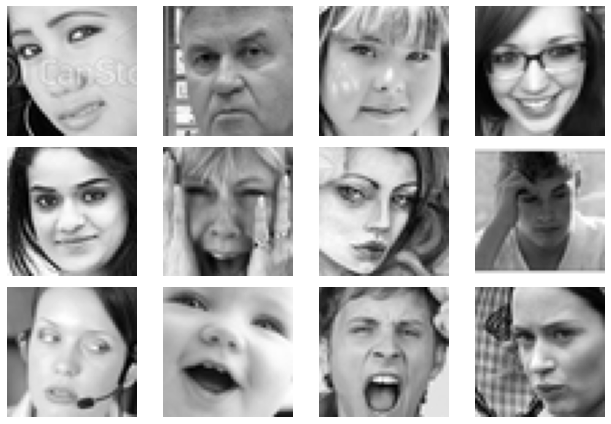

In [34]:
plt.figure(0, figsize=(9,6))
for i in range(1,13):
    plt.subplot(3,4,i)
    plt.axis('off')
    image = test_images[i].reshape(48,48)
    plt.imshow(image, cmap="gray")

plt.tight_layout()
plt.show()

# **DERİN EVRİŞİMLİ SİNİR AĞI MODELİ TANIMLANMASI**

In [35]:
#sequential ile boş bir hacim tasarlanır.
model=Sequential()
#1. KATMAN 3 filtreden oluşuyor.
model.add(Conv2D(64, 3, data_format="channels_last", kernel_initializer="he_normal", input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation("relu"))
#2. KATMAN
model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.2)) #%20 unutma işlemi(nöron silme-dropout)
#3. KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
#4. KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
#5. KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.2)) #%20 unutma işlemi(nöron silme-dropout)

#6. KATMAN
model.add(Conv2D(128, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
#7. KATMAN
model.add(Conv2D(256, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

# TAM BAĞLANTI KATMANI Flatten komutuyla matris vektör haline çevirilir. Dense ile de tam bağlantı sağlanır.

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))
#ÇIKIŞ KATMANI Dense, 7 sınıf sayısı kadar seçilir
model.add(Dense(7))
model.add(Activation('softmax')) #Sınıflama işlemi (7 duygu sınıfı var)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #opmizasyon ve başarım hesaplama metriklerinin belirlenmesi
model.summary() #model özetini görselleştirelim

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 44, 44, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 44, 44, 64)       

Eğtim ve Test kümelerinin eleman sayısı, yükseklik ve genişlik, kanalsayısı bilgilerini ekrana yazdıralım.

In [36]:
x_train = train_images.reshape(-1, 48, 48, 1)
x_test = test_images.reshape(-1, 48, 48, 1)

print("Train:", x_train.shape)
print("Test:", x_test.shape)
#eğitim train için 28709 tane 48x48 filtreli ve bir kanallı görüntümüz var 

Train: (28709, 48, 48, 1)
Test: (3589, 48, 48, 1)


In [37]:
#Kümeler içine elean ve duygu sınıfalrı sayısı
print("Train:", y_train.shape)
print("Test:", y_test.shape)

Train: (28709, 7)
Test: (3589, 7)


**Eğitim işleminin gerçekleşmesini istediğimiz epoch, batchsize gibi değerlerin belirlenmesi ve eğitim sonucunda ağırlıkların .h5 dosyası olarak kaydedilmesi işlemleri**

In [38]:
# en başarılı ağırlıkları kaydet
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab_Notebooks/input/ModelCheckpoint', verbose=1, save_best_only=True)

epochs = 20
batchSize = 256

In [39]:
# modeli çalıştır model.fit çalıştırılacak olan alan
hist = model.fit(x_train, y_train, #model eğitilir
                 epochs=epochs,
                 shuffle=True,
                 batch_size=batchSize, 
                 validation_data=(x_test, y_test),
                 callbacks=[checkpointer], verbose=2)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.70965, saving model to /content/drive/MyDrive/Colab_Notebooks/input/ModelCheckpoint


113/113 - 24s - loss: 1.6772 - accuracy: 0.3631 - val_loss: 1.7096 - val_accuracy: 0.3190 - 24s/epoch - 214ms/step
Epoch 2/20

Epoch 2: val_loss improved from 1.70965 to 1.44060, saving model to /content/drive/MyDrive/Colab_Notebooks/input/ModelCheckpoint


113/113 - 11s - loss: 1.3900 - accuracy: 0.4686 - val_loss: 1.4406 - val_accuracy: 0.4639 - 11s/epoch - 101ms/step
Epoch 3/20

Epoch 3: val_loss improved from 1.44060 to 1.28743, saving model to /content/drive/MyDrive/Colab_Notebooks/input/ModelCheckpoint


113/113 - 11s - loss: 1.2643 - accuracy: 0.5198 - val_loss: 1.2874 - val_accuracy: 0.5199 - 11s/epoch - 101ms/step
Epoch 4/20

Epoch 4: val_loss improved from 1.28743 to 1.25842, saving model to /content/drive/MyDrive/Colab_Notebooks/input/ModelCheckpoint


113/113 - 12s - loss: 1.1684 - accuracy: 0.5568 - val_loss: 1.2584 - val_accuracy: 0.5261 - 12s/epoch - 102ms/step
Epoch 5/20

Epoch 5: val_loss improved from 1.25842 to 1.18778, saving model to /content/drive/MyDrive/Colab_Notebooks/input/ModelCheckpoint


113/113 - 12s - loss: 1.0994 - accuracy: 0.5831 - val_loss: 1.1878 - val_accuracy: 0.5584 - 12s/epoch - 103ms/step
Epoch 6/20

Epoch 6: val_loss did not improve from 1.18778
113/113 - 8s - loss: 1.0393 - accuracy: 0.6078 - val_loss: 1.1956 - val_accuracy: 0.5522 - 8s/epoch - 74ms/step
Epoch 7/20

Epoch 7: val_loss did not improve from 1.18778
113/113 - 8s - loss: 0.9855 - accuracy: 0.6268 - val_loss: 1.2069 - val_accuracy: 0.5458 - 8s/epoch - 73ms/step
Epoch 8/20

Epoch 8: val_loss did not improve from 1.18778
113/113 - 8s - loss: 0.9325 - accuracy: 0.6540 - val_loss: 1.1926 - val_accuracy: 0.5706 - 8s/epoch - 73ms/step
Epoch 9/20

Epoch 9: val_loss improved from 1.18778 to 1.17614, saving model to /content/drive/MyDrive/Colab_Notebooks/input/ModelCheckpoint


113/113 - 11s - loss: 0.8683 - accuracy: 0.6778 - val_loss: 1.1761 - val_accuracy: 0.5890 - 11s/epoch - 101ms/step
Epoch 10/20

Epoch 10: val_loss did not improve from 1.17614
113/113 - 8s - loss: 0.8182 - accuracy: 0.6956 - val_loss: 1.1873 - val_accuracy: 0.5929 - 8s/epoch - 72ms/step
Epoch 11/20

Epoch 11: val_loss did not improve from 1.17614
113/113 - 8s - loss: 0.7732 - accuracy: 0.7114 - val_loss: 1.1780 - val_accuracy: 0.5985 - 8s/epoch - 72ms/step
Epoch 12/20

Epoch 12: val_loss did not improve from 1.17614
113/113 - 8s - loss: 0.7175 - accuracy: 0.7327 - val_loss: 1.2142 - val_accuracy: 0.5896 - 8s/epoch - 72ms/step
Epoch 13/20

Epoch 13: val_loss did not improve from 1.17614
113/113 - 8s - loss: 0.6605 - accuracy: 0.7566 - val_loss: 1.2480 - val_accuracy: 0.5776 - 8s/epoch - 72ms/step
Epoch 14/20

Epoch 14: val_loss did not improve from 1.17614
113/113 - 8s - loss: 0.6102 - accuracy: 0.7740 - val_loss: 1.2896 - val_accuracy: 0.5787 - 8s/epoch - 72ms/step
Epoch 15/20

Epoch 1

In [40]:
# save model to json
model_json = model.to_json()
with open("/content/drive/MyDrive/Colab_Notebooks/input/ModelCheckpoint/saved_model.pb", "w") as json_file:
  json_file.write(model_json)

In [41]:
import shutil
model.save("/content/drive/MyDrive/Colab_Notebooks/input/ModelCheckpoint/variables/face_model2.h5")
shutil.make_archive('myy_model', 'zip', '/content/drive/MyDrive/Colab_Notebooks/input/myy_model')

'/content/drive/MyDrive/Colab_Notebooks/input/myy_model.zip'

**Eğitim sonucu elde edilen Eğitim ve Geçerleme (Validation) sonuçlarının grafiksel olarak ifade edilip ekrarna yazdırılması işlemleri.**

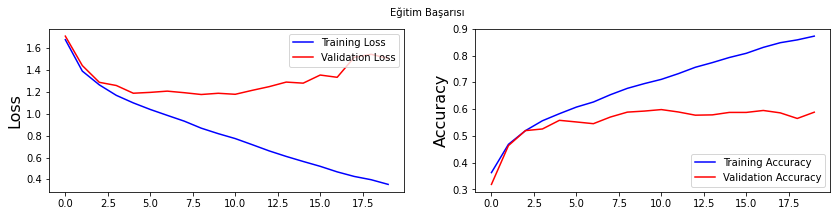

In [42]:
# Plot training & validation accuracy values figure subplot plot fonksiyonları kullanılır. 
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Eğitim Başarısı', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show() #ekraan göster

In [43]:
#**PrivateTest** örnekleri ile test edelim.
test = data[["emotion", "pixels"]][data["Usage"] == "PrivateTest"]
test["pixels"] = test["pixels"].apply(lambda im: np.fromstring(im, sep=' '))
test.head()

,emotion,pixels
32298,0,"[170.0, 118.0, 101.0, 88.0, 88.0, 75.0, 78.0, 82.0, 66.0, 74.0, 68.0, 59.0, 63.0, 64.0, 65.0, 90..."
32299,5,"[7.0, 5.0, 8.0, 6.0, 7.0, 3.0, 2.0, 6.0, 5.0, 4.0, 4.0, 5.0, 7.0, 5.0, 5.0, 5.0, 6.0, 7.0, 7.0, ..."
32300,6,"[232.0, 240.0, 241.0, 239.0, 237.0, 235.0, 246.0, 117.0, 24.0, 24.0, 22.0, 13.0, 12.0, 14.0, 9.0..."
32301,4,"[200.0, 197.0, 149.0, 139.0, 156.0, 89.0, 111.0, 58.0, 62.0, 95.0, 113.0, 117.0, 116.0, 116.0, 1..."
32302,2,"[40.0, 28.0, 33.0, 56.0, 45.0, 33.0, 31.0, 78.0, 152.0, 194.0, 200.0, 186.0, 196.0, 207.0, 194.0..."


In [44]:
x_test_private = np.vstack(test["pixels"].values)
y_test_private = np.array(test["emotion"])

In [45]:
x_test_private = x_test_private.reshape(-1, 48, 48, 1)
y_test_private = np_utils.to_categorical(y_test_private)
;
x_test_private.shape, y_test_private.shape

((3589, 48, 48, 1), (3589, 7))

In [46]:
score = model.evaluate(x_test_private, y_test_private, verbose=0)
print("PrivateTest üzerinde doğruluk başarımı:", score)

PrivateTest üzerinde doğruluk başarımı: [1.476759910583496, 0.5979381203651428]


Veri kümesindeki eğitim kısmı ile modeli eğitip test için ayırılan veri ile test işlemlerini yaptık. *
Şimdi de veriseti dışındaki Farklı görüntülerle test işlemlerini yapıp sonuçları görselleştirelim

In [47]:
from keras.models import load_model
from PIL import Image
from keras.preprocessing import image

import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy

from scipy import ndimage
#from lr_utils import load_dataset

%matplotlib inline

Gerekli kütüphanleri kurup, daha önceki eğitimde kaydettiğimiz modelin hesapladığını öğrenilmiş ağırlık dosyasını kullanıyoruz.

In [48]:
data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/input/ModelCheckpoint/data/fer2013.csv')
data.shape

(35887, 3)

In [50]:
# en iyi ağırlıkları yükle, önceki modelle beraber kullanımı sağlanırr
loaded = keras.models.load_model("/content/drive/MyDrive/Colab_Notebooks/input/ModelCheckpoint/variables/face_model2.h5")

1/1 [==============================] - 0s 318ms/step


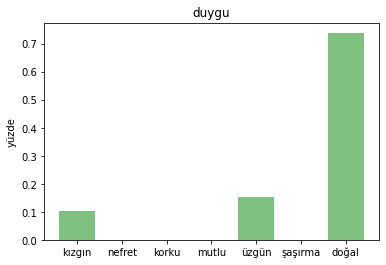

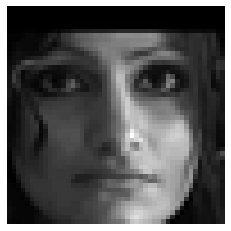

In [51]:
test_image=x_test_private[15]

custom = model.predict(test_image.reshape(-1, 48, 48, 1))

#1 boyutlandır
objects = ('kızgın', 'nefret', 'korku', 'mutlu', 'üzgün', 'şaşırma', 'doğal')
y_pos = np.arange(len(objects))
    
plt.bar(y_pos, custom[0], align='center', alpha=0.5, color='g')
plt.xticks(y_pos, objects)
plt.ylabel('yüzde')
plt.title('duygu')
plt.show()

#2 array halne getir. Veritabanındaki görseller hep dizi (array) şeklindedir.
x = np.array([48, 48], 'float32')
#x = x.reshape([48, 48);
plt.axis('off')
plt.gray()
plt.imshow(test_image.reshape(48,48))

plt.show()

1/1 [==============================] - 0s 16ms/step


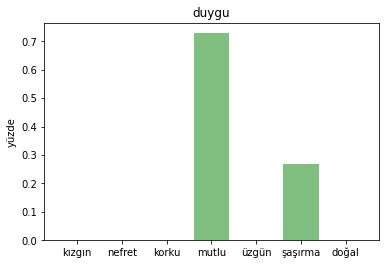

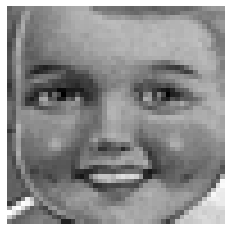

In [52]:
test_image=x_test[30]

custom = model.predict(test_image.reshape(-1, 48, 48, 1))

#1
objects = ('kızgın', 'nefret', 'korku', 'mutlu', 'üzgün', 'şaşırma', 'doğal')
y_pos = np.arange(len(objects))
    
plt.bar(y_pos, custom[0], align='center', alpha=0.5, color='g')
plt.xticks(y_pos, objects)
plt.ylabel('yüzde')
plt.title('duygu')
plt.show()

#2
x = np.array([48, 48], 'float32')
#x = x.reshape([48, 48);
plt.axis('off')
plt.gray()
plt.imshow(test_image.reshape(48,48))

plt.show()

In [53]:
# Kendi örneklerimizle test işlem adımları

In [54]:
import cv2

In [55]:
x_test_private = test_images[5].reshape(-1, 48, 48, 1)

In [56]:
!ls '/content/drive/MyDrive/Udemy_DerinOgrenmeyeGiris/Evrisimli_Sinir_Aglari/Duygu_Tanima/images'

bb1.jpg     hababam.jpg        kemal_sunal.jpg	lotr3.jpg	  test4.jpg
bb2.jpg     javierbardem2.jpg  kizgin.jpeg	robertdeniro.jpg  test5.jpg
brando.png  javierbardem.jpg   lotr1.png	test2.jpg	  test6.jpg
emojis	    kemal_sunal2.jpg   lotr2.jpg	test3.jpg	  test.jpg


In [57]:
image_path = "/content/drive/MyDrive/Udemy_DerinOgrenmeyeGiris/Evrisimli_Sinir_Aglari/Duygu_Tanima/images/brando.png"
import keras.utils as image
from tensorflow.keras.utils import load_img

test_image_original = image.load_img(image_path) # orjinal renkli görüntü

test_image = image.load_img(image_path, target_size=(48, 48), grayscale=True)
test_data = image.img_to_array(test_image)

test_data = np.expand_dims(test_data, axis=0)
test_data = np.vstack([test_data])

results = model.predict(test_data, batch_size=1)
results

1/1 [==============================] - 0s 15ms/step


/usr/local/lib/python3.8/dist-packages/keras/utils/image_utils.py:382: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


array([[1.12197979e-03, 1.14935036e-04, 1.02763154e-01, 2.10768417e-01,
        6.78890765e-01, 2.76374310e-04, 6.06435072e-03]], dtype=float32)

In [58]:
from google.colab.patches import cv2_imshow

1/1 [==============================] - 0s 156ms/step


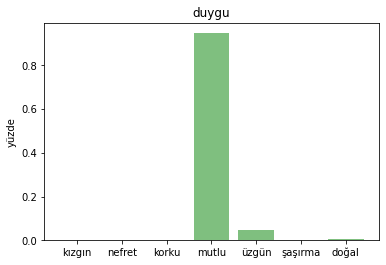

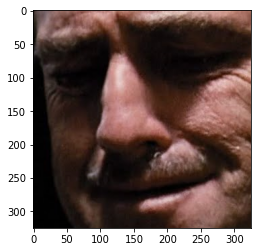

In [59]:
from tensorflow.keras.preprocessing import image

test_image="/content/drive/MyDrive/Udemy_DerinOgrenmeyeGiris/Evrisimli_Sinir_Aglari/Duygu_Tanima/images/brando.png"
img = image.load_img(test_image, target_size=(48, 48))
img_array = image.img_to_array(img)

custom = model.predict(img_array.reshape(-1,48,48,1))

#1
objects = ('kızgın', 'nefret', 'korku', 'mutlu', 'üzgün', 'şaşırma', 'doğal')
y_pos = np.arange(len(objects))
    
plt.bar(y_pos, custom[0], align='center', alpha=0.5, color='g')
plt.xticks(y_pos, objects)
plt.ylabel('yüzde')
plt.title('duygu')
plt.show()

#2
x = np.array([48, 48], 'float32')
#x = x.reshape([48, 48]);
plt.axis('off')
plt.gray()

import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow
%matplotlib inline
testim = mpimg.imread('/content/drive/MyDrive/Udemy_DerinOgrenmeyeGiris/Evrisimli_Sinir_Aglari/Duygu_Tanima/images/brando.png')
imshow(testim)


plt.show("/content/drive/MyDrive/Udemy_DerinOgrenmeyeGiris/Evrisimli_Sinir_Aglari/Duygu_Tanima/images/brando.png")

1/1 [==============================] - 0s 16ms/step


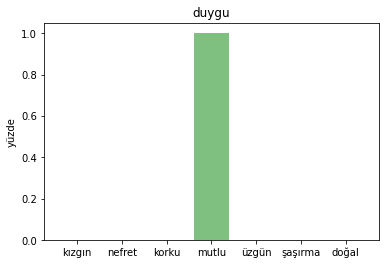

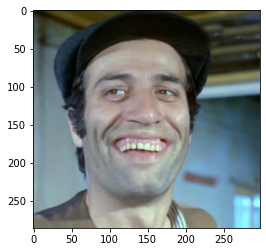

In [60]:
test_image="/content/drive/MyDrive/Udemy_DerinOgrenmeyeGiris/Evrisimli_Sinir_Aglari/Duygu_Tanima/images/kemal_sunal2.jpg"
img = image.load_img(test_image, target_size=(48, 48))
img_array = image.img_to_array(img)

custom = model.predict(img_array.reshape(-1,48,48,1))

#1
objects = ('kızgın', 'nefret', 'korku', 'mutlu', 'üzgün', 'şaşırma', 'doğal')
y_pos = np.arange(len(objects))
    
plt.bar(y_pos, custom[0], align='center', alpha=0.5, color='g')
plt.xticks(y_pos, objects)
plt.ylabel('yüzde')
plt.title('duygu')
plt.show()

#2
x = np.array([48, 48], 'float32')
#x = x.reshape([48, 48]);
plt.axis('off')
plt.gray()

import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow
%matplotlib inline
testim = mpimg.imread('/content/drive/MyDrive/Udemy_DerinOgrenmeyeGiris/Evrisimli_Sinir_Aglari/Duygu_Tanima/images/kemal_sunal2.jpg')
imshow(testim)


plt.show("/content/drive/MyDrive/Udemy_DerinOgrenmeyeGiris/Evrisimli_Sinir_Aglari/Duygu_Tanima/images/kemal_sunal2.jpg")

1/1 [==============================] - 0s 18ms/step


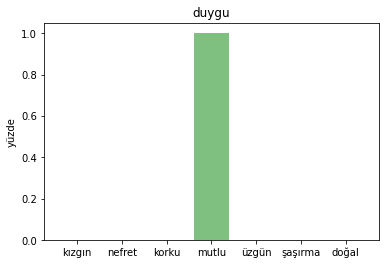

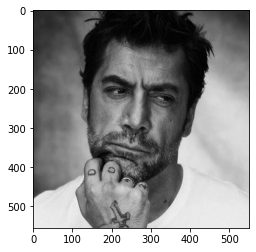

In [61]:
test_image="/content/drive/MyDrive/Udemy_DerinOgrenmeyeGiris/Evrisimli_Sinir_Aglari/Duygu_Tanima/images/javierbardem.jpg"
img = image.load_img(test_image, target_size=(48, 48))
img_array = image.img_to_array(img)

custom = model.predict(img_array.reshape(-1,48,48,1))

#1
objects = ('kızgın', 'nefret', 'korku', 'mutlu', 'üzgün', 'şaşırma', 'doğal')
y_pos = np.arange(len(objects))
    
plt.bar(y_pos, custom[0], align='center', alpha=0.5, color='g')
plt.xticks(y_pos, objects)
plt.ylabel('yüzde')
plt.title('duygu')
plt.show()

#2
x = np.array([48, 48], 'float32')
#x = x.reshape([48, 48]);
plt.axis('off')
plt.gray()

import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow
%matplotlib inline
testim = mpimg.imread('/content/drive/MyDrive/Udemy_DerinOgrenmeyeGiris/Evrisimli_Sinir_Aglari/Duygu_Tanima/images/javierbardem.jpg')
imshow(testim)


plt.show("/content/drive/MyDrive/Udemy_DerinOgrenmeyeGiris/Evrisimli_Sinir_Aglari/Duygu_Tanima/images/javierbardem.jpg")

1/1 [==============================] - 0s 18ms/step


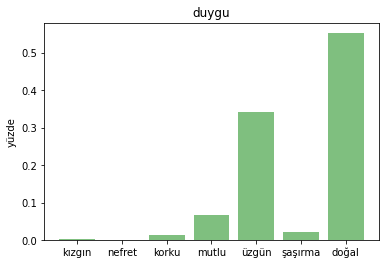

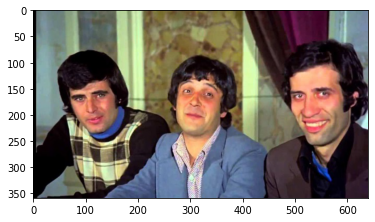

In [62]:
test_image="/content/drive/MyDrive/Udemy_DerinOgrenmeyeGiris/Evrisimli_Sinir_Aglari/Duygu_Tanima/images/hababam.jpg"
img = image.load_img(test_image, target_size=(48, 48))
img_array = image.img_to_array(img)

custom = model.predict(img_array.reshape(-1,48,48,1))

#1
objects = ('kızgın', 'nefret', 'korku', 'mutlu', 'üzgün', 'şaşırma', 'doğal')
y_pos = np.arange(len(objects))
    
plt.bar(y_pos, custom[0], align='center', alpha=0.5, color='g')
plt.xticks(y_pos, objects)
plt.ylabel('yüzde')
plt.title('duygu')
plt.show()

#2
x = np.array([48, 48], 'float32')
#x = x.reshape([48, 48]);
plt.axis('off')
plt.gray()

import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow
%matplotlib inline
testim = mpimg.imread('/content/drive/MyDrive/Udemy_DerinOgrenmeyeGiris/Evrisimli_Sinir_Aglari/Duygu_Tanima/images/hababam.jpg')
imshow(testim)


plt.show("/content/drive/MyDrive/Udemy_DerinOgrenmeyeGiris/Evrisimli_Sinir_Aglari/Duygu_Tanima/images/hababam.jpg")

In [63]:
import zipfile
with zipfile.ZipFile("myy_model.zip","r") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/Colab_Notebooks/input/myy_model")

**SONUÇLARIN GÖRSELLEŞTİRİLMESİ ADIMLARI**

In [63]:
#sınıflarımız 7 adet duygu durumumuz
class_names = ['kizgin', 'igrenme', 'korku', 'mutlu', 'uzgun', 'sasirma', 'dogal']

ind = 0.1+0.6*np.arange(len(class_names))
width = 0.4  #bar genişliği

color_list = ['red','orangered','darkorange','limegreen','darkgreen','royalblue','navy']

# test resmimizi çizdirelim

plt.imshow(test_image_original)
plt.title('Giriş Resmi', fontsize=16)
plt.axis('off')
plt.show()

#sonuçlarımızı renklendirelim

for i in range(len(class_names)):
  plt.bar(ind[i], results[0][i], width, color=color_list[i])

plt.title("Sınıflandırma Sonuçları", fontsize=20)
plt.xlabel("Yüz İfadeleri Kategorisi",fontsize=16)
plt.ylabel("Sınıflandırma Skoru",fontsize=16)
plt.xticks(ind, class_names, rotation=45, fontsize=14)
plt.show()


print("Sınıflandırma sonucu en yüksek oranla:", class_names[np.argmax(results)])

# en yüksek skorlu duyguya karşılık emoji çizdirelim

emojis_img = image.load_img(root + 'images/emojis/%s.png'% str(class_names[np.argmax(results)]))

plt.imshow(emojis_img)
plt.axis('off')
plt.show()